In [137]:
#install.packages("caTools")
#install.packages("e1071")
install.packages("ROCR")

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependencies ‘gtools’, ‘gplots’




In [138]:
library(caTools)
library(e1071)
library(ROCR)

In [73]:
donnees <- read.table("maj_data.data", header = TRUE, sep = ",")

In [79]:
head(donnees)

,X,X2,X30,X2.1,X1,X2.2,X2.3,X2.4,X2.5,X1.1,⋯,X2.7,X2.8,X2.9,X2.10,X1.00,X85,X18,X4.0,X.,X1.2
,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,⋯,<int>,<int>,<int>,<int>,<dbl>,<dbl>,<int>,<dbl>,<dbl>,<int>
1,1,2,50,1,1,2,1,2,2,1,⋯,2,2,2,2,0.9,135.000,42,3.5,61.85227,1
2,2,2,78,1,2,2,1,2,2,2,⋯,2,2,2,2,0.7,96.000,32,4.0,61.85227,1
3,4,2,34,1,2,2,2,2,2,2,⋯,2,2,2,2,1.0,105.488,200,4.0,61.85227,1
4,5,2,34,1,2,2,2,2,2,2,⋯,2,2,2,2,0.9,95.000,28,4.0,75.00000,1
5,8,2,39,1,2,2,1,2,2,2,⋯,2,2,2,2,0.7,105.488,48,4.4,61.85227,1
6,9,2,30,1,2,2,2,2,2,2,⋯,2,2,2,2,1.0,105.488,120,3.9,61.85227,1


In [80]:
print(colnames(donnees))

 [1] "X"     "X2"    "X30"   "X2.1"  "X1"    "X2.2"  "X2.3"  "X2.4"  "X2.5" 
[10] "X1.1"  "X2.6"  "X2.7"  "X2.8"  "X2.9"  "X2.10" "X1.00" "X85"   "X18"  
[19] "X4.0"  "X."    "X1.2" 


In [81]:
#On identifie automatiquement les variables potentielles dépendantes
variables_dependantes_potentielles <- character(0)

for (col in names(donnees)) {
  unique_vals <- unique(donnees[[col]])

  #On vérifie si la variable a seulement deux niveaux (binaire)
  if (length(unique_vals) == 2) {
    variables_dependantes_potentielles <- c(variables_dependantes_potentielles, col)
  }
}

#On affiche les variables potentielles dépendantes
print(variables_dependantes_potentielles)

 [1] "X2"    "X2.1"  "X1"    "X2.2"  "X2.3"  "X2.4"  "X2.5"  "X1.1"  "X2.6" 
[10] "X2.7"  "X2.8"  "X2.9"  "X2.10" "X1.2" 


In [82]:
param_interet <- "X1.2"

In [83]:
head(donnees[param_interet])

,X1.2
,<int>
1,1
2,1
3,1
4,1
5,1
6,1


In [87]:
#Fonction permettant l'application du modèle RandomForest
# parametres : le dataset, le paramètre d'interet

fonctionSVM <- function(donnees, interet, type) {
  SVM = NULL
  set.seed(123)

  #on recupère l'index du parametre d'interet
  index_X = which(colnames(donnees) == interet)

  #Faire de la variable dependante un facteur (categorique)
  #donnees[[interet]] pour donnees$interet
  donnees[[interet]] <- as.factor(donnees[[interet]])

  #echantillonnage trainset et testset
  ind <- sample(2, nrow(donnees), replace = TRUE, prob=c(0.7, 0.3))
  data_train <- donnees[ind == 1,]
  data_test <- donnees[ind == 2,]

  #Etape importante dans de nombreux algorithmes d'apprentissage automatique,
  # y compris les machines à vecteurs de support (SVM). Cette pratique vise à normaliser
  # les caractéristiques du jeu de données, c'est-à-dire à les ramener à une échelle commune

  #Feature Scaling sauf sur le parametre d'interet
  data_train[-index_X] <- scale(data_train[-index_X])
  data_test[-index_X] <- scale(data_test[-index_X])

  #construction du modele
  if (type == "linéaire"){
    SVM = svm(as.formula(paste(interet, "~ .")), data = data_train, type = 'C-classification', kernel = 'linear')
    print(SVM)
  }

  else if(type == "radial"){
    SVM = svm(as.formula(paste(interet, "~ .")), data = data_train, type = 'C-classification', kernel = 'radial', gamma = 0.01)
    print(SVM)
  }


  cat("\n\n")

  #prediction
  pred <- predict(SVM, data_test)

  #Matrice de confusion
  mat_conf <- table(observed = data_test[[interet]], predicted = pred)
  cat("Matrice de condusion sur de nouvelles données:\n\n")
  print(mat_conf)

  return(list(SVM, data_train, data_test, mat_conf))
}

In [95]:
model_svm <- fonctionSVM(donnees, param_interet, "linéaire")

donnees_svm <- model_svm[[1]]
donnees_train <- model_svm[[2]]
donnees_test <- model_svm[[3]]
mat_c <- model_svm[[4]]


Call:
svm(formula = as.formula(paste(interet, "~ .")), data = data_train, 
    type = "C-classification", kernel = "linear")


Parameters:
   SVM-Type:  C-classification 
 SVM-Kernel:  linear 
       cost:  1 

Number of Support Vectors:  28



Matrice de condusion sur de nouvelles données:

        predicted
observed  1  2
       1 20  2
       2  1 14


In [96]:
getPrecision_Recall_FScore <- function(mat_conf) {
  #On extrait les valeurs de la matrice de confusion
  tp <- mat_conf[2, 2]  # True Positives
  fp <- mat_conf[1, 2]  # False Positives
  fn <- mat_conf[2, 1]  # False Negatives

  print(tp)
  print(fp)
  print(fn)

  # Calculer la précision, le rappel et le F-score
  precision <- tp / (tp + fp)
  recall <- tp / (tp + fn)
  fscore <- 2 * (precision * recall) / (precision + recall)


  # Afficher les résultats
  cat("Precision:", precision, "\n")
  cat("Recall:", recall, "\n")
  cat("Fscore:", fscore, "\n")

  return(c(precision,recall,fscore))
}

In [97]:
res <- getPrecision_Recall_FScore(mat_c)

[1] 14
[1] 2
[1] 1
Precision: 0.875 
Recall: 0.9333333 
Fscore: 0.9032258 


In [135]:
afficheROC <- function(SVM,donnees_test,interet){

  #Prédiction des probabilités avec le modèle svm sur le jeu de données de test
  pred_prob <- predict(SVM, newdata = donnees_test, type = "prob")

  #Extraction des probabilités associées à la classe positive (2ème colonne)
  pred_positive <- as.numeric(levels(pred_prob))[pred_prob]

  #Obtention des vraies étiquettes (valeurs de la variable cible) à partir du jeu de données de test
  true_labels <- donnees_test[[interet]]

  #Création d'un objet de performance en utilisant les probabilités prédites et les vraies étiquettes
  perf <- prediction(pred_positive, true_labels)

  #AUC
  auc <- performance(perf, "auc")
  cat("AUC = ", auc@y.values[[1]])

  #TPR FPR
  pred3 <- performance(perf, "tpr","fpr")

  #ROC curve
  plot(pred3,main="ROC Curve pour le Random Forest",col=2,lwd=2)
  abline(a=0,b=1,lwd=2,lty=2,col="gray")
}

AUC =  0.9212121

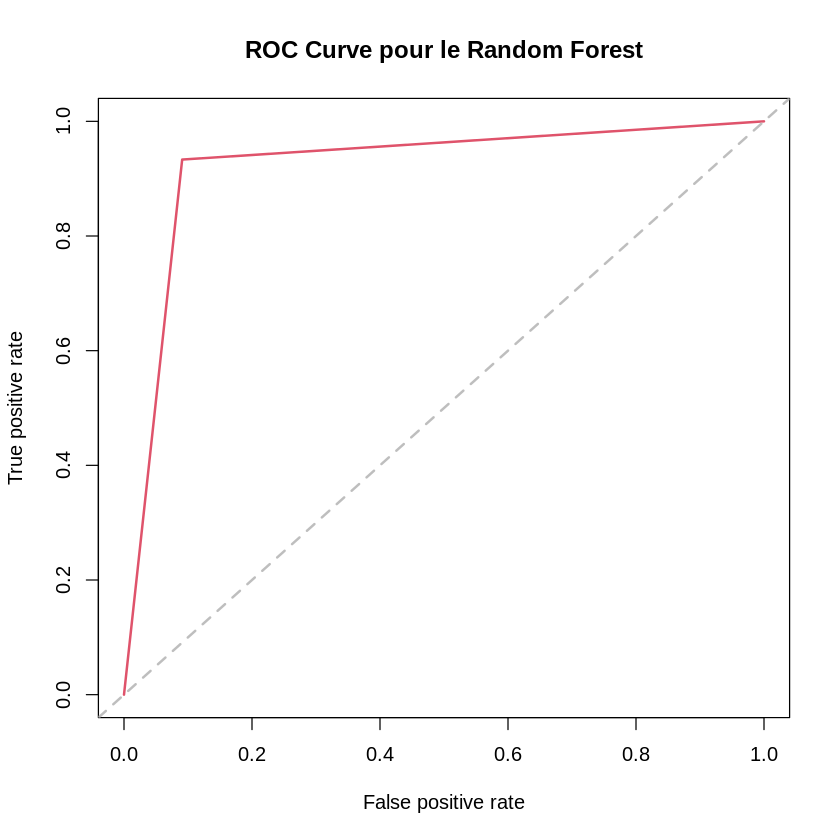

In [141]:
afficheROC(donnees_svm,donnees_test,param_interet)

In [143]:
model_svmr <- fonctionSVM(donnees, param_interet, "radial")

donnees_svmr <- model_svmr[[1]]
donnees_trainr <- model_svmr[[2]]
donnees_testr <- model_svmr[[3]]
mat_cr <- model_svmr[[4]]


Call:
svm(formula = as.formula(paste(interet, "~ .")), data = data_train, 
    type = "C-classification", kernel = "radial", gamma = 0.01)


Parameters:
   SVM-Type:  C-classification 
 SVM-Kernel:  radial 
       cost:  1 

Number of Support Vectors:  66



Matrice de condusion sur de nouvelles données:

        predicted
observed  1  2
       1 20  2
       2  2 13


In [144]:
res <- getPrecision_Recall_FScore(mat_cr)

[1] 13
[1] 2
[1] 2
Precision: 0.8666667 
Recall: 0.8666667 
Fscore: 0.8666667 


AUC =  0.8878788

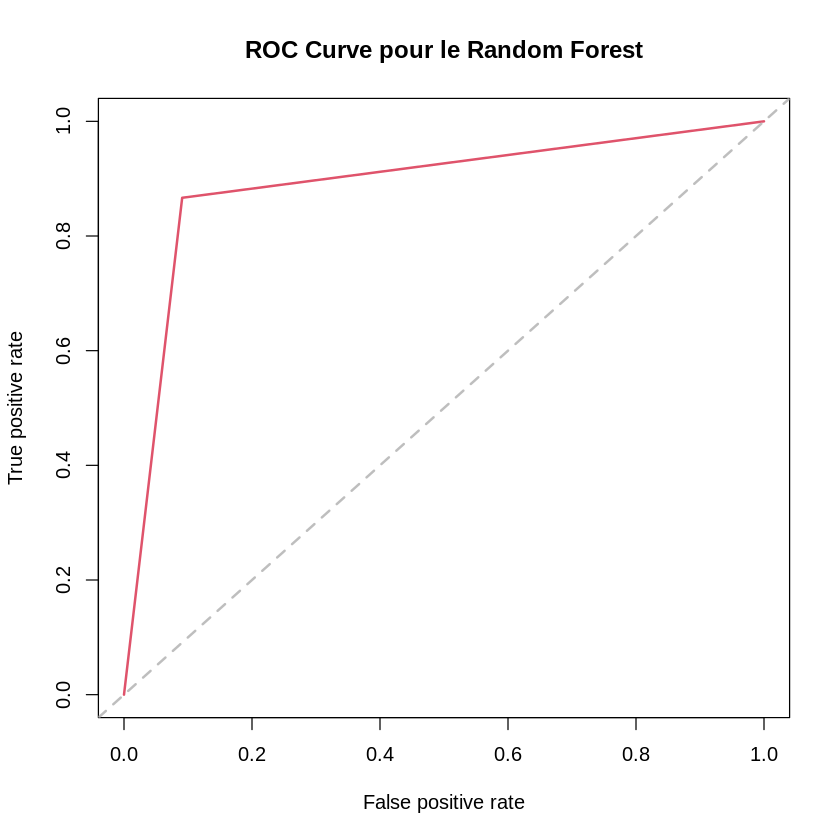

In [145]:
afficheROC(donnees_svmr,donnees_test,param_interet)